# Clasificación con redes neuronales

Alfredo Rodríguez Magdalena ©

In [2]:
import mat73
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import tensorflow as tf
from keras import Sequential, Input
from keras.layers import Dense, BatchNormalization, Dropout, concatenate
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.models import Model

In [3]:
sys.path.append(r'../utils/')

from mostrarDatos import visualizarPerfiles
from segmentarDatos import obtenerExperimento

In [10]:
data = mat73.loadmat(r'../datos/experimento3_sep.mat')
labels = scipy.io.loadmat(r'../datos/labelsExperimento3.mat')
Vr14 = scipy.io.loadmat(r'../datos/Vr14.mat')

X = data["X"]
U = data["U"]
N = data["N"]
Y = labels['Y']
Vr14 = Vr14['Vr14']

sizeExp = np.insert(data["N"],0,0).astype(int)
sizeExp = sizeExp[1:]

tm = 5e-3 # Tiempo de muestreo
Q = np.size(U,0) # Número de muestras
t = np.arange(0, Q*tm, tm) # Vector de tiempo

print(f"Dimensiones de los datos = {X.T.shape} (espacio, tiempo)")
print(f"Número de experimentos : {len(sizeExp)-1}")
print(f"Longitud de los primeros 5 experimentos : {sizeExp[:5]}")
print(f"Dimensiones de las etiquetas : {Y.shape}")
print(f"Dimensiones de la matriz de cambio de base : {Vr14.shape}")

Dimensiones de los datos = (500, 11953) (espacio, tiempo)
Número de experimentos : 35
Longitud de los primeros 5 experimentos : [318 340 340 359 341]
Dimensiones de las etiquetas : (11953, 1)
Dimensiones de la matriz de cambio de base : (15, 500)


In [ ]:
# Reducción de la dimensión de los datos
alpha = Vr14 @ X.T

Tras reducir la dimensión de los datos, se procederá a dividirlos en los subconjuntos de entrenamiento, validación y test correspondientes.

In [87]:
np.random.seed(92) # Semilla para reproducibilidad

# Se usa el 60% del conjunto de datos como el conjunto de entrenamiento. Y se pondrá el 40% restante en las variables
# temporales x_ y y_.
Xtrain, x_, yTrain, y_ = train_test_split(alpha.T, Y, test_size = 0.4, random_state=1)

# El 40% restante se subdivide en partes iguales para el conjunto de validación cruzada y el de prueba
Xcv, Xtest, yCV, yTest = train_test_split(x_, y_, test_size=0.5, random_state=1)

# Se eliminan las variables temporales
del x_, y_

numAtributos = Xtrain.shape[1]
numClases = 3

print('Las dimensiones del subconjunto de entrenamiento (Atributos) son: ' + str(Xtrain.shape))
print('Las dimensiones del subconjunto de entrenamiento (Etiquetas) son: ' + str(yTrain.shape) + '\n')

print('Las dimensiones del subconjunto de validación cruzada (Atributos) son: ' + str(Xcv.shape))
print('Las dimensiones del subconjunto de validación cruzada (Etiquetas) son: ' + str(yCV.shape) + '\n')

print('Las dimensiones del subconjunto de prueba (Atributos) son: ' + str(Xtest.shape))
print('Las dimensiones del subconjunto de prueba (Etiquetas) son: ' + str(yTest.shape))

Las dimensiones del subconjunto de entrenamiento (Atributos) son: (7171, 15)
Las dimensiones del subconjunto de entrenamiento (Etiquetas) son: (7171, 1)

Las dimensiones del subconjunto de validación cruzada (Atributos) son: (2391, 15)
Las dimensiones del subconjunto de validación cruzada (Etiquetas) son: (2391, 1)

Las dimensiones del subconjunto de prueba (Atributos) son: (2391, 15)
Las dimensiones del subconjunto de prueba (Etiquetas) son: (2391, 1)


Se harán pruebas con 3 tipos de arquitecturas de redes neuronales. Inicialmente se empleará un perceptrón multicapa, después, se entrenará un perceptrón multicapa de mayor tamaño pero aplicando la técnica del dropout para que no haya sobreentrenamiento, y finalmente se construirá una red _Fully Connected Cascade_ (FFC).

In [110]:
# Modelo FCC

# Definir la entrada
input_layer = Input(shape=(numAtributos,))

# Primera capa oculta
hidden1 = Dense(units=8, activation='relu')(input_layer)

# Segunda capa oculta
hidden2 = Dense(units=8, activation='relu')(hidden1)

# Concatenar la entrada original con la salida de la segunda capa oculta
concat1 = concatenate([input_layer, hidden2])

# Tercera capa oculta
hidden3 = Dense(units=8, activation='relu')(concat1)

# Concatenar la entrada original y la salida de la primera y tercera capa oculta
concat2 = concatenate([input_layer, hidden1, hidden3])

# Capa de salida
output_layer = Dense(units=numClases, activation='softmax')(concat2)

# Definir el modelo
modeloFCC = Model(inputs=input_layer, outputs=output_layer)

modeloFCC.name = 'FFC'


In [114]:
modelos = [
    # 1. MLP (Multilayer Perceptron)
    Sequential([
        Input(shape=(numAtributos,)),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),
        Dense(numClases, activation='softmax')
    ],name = 'MLP'),
    # 2. BMLP (Batched Multilayer Perceptron)
    Sequential([
        Input(shape=(numAtributos,)),
        # Primera capa oculta
        Dense(64, input_dim=numAtributos, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        # Segunda capa oculta
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        # Capa de salida
        Dense(numClases, activation='softmax')
    ],name = 'BMLP'),
    # 3. FCC (Fully Connected Cascade)
    modeloFCC
]

In [115]:
for model in modelos:
    model.summary()

Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_112 (Dense)               │ (None, 16)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 419 (1.64 KB)

 Trainable params: 419 (1.64 KB)

 Non-trainable params: 0 (0.00 B)

Model: "BMLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_115 (Dense)               │ (None, 64)             │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_116 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,587 (14.01 KB)

 Trainable params: 3,395 (13.26 KB)

 Non-trainable params: 192 (768.00 B)

Model: "FFC"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_96 (Dense)    │ (None, 8)         │        128 │ input_layer_29[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_97 (Dense)    │ (None, 8)         │         72 │ dense_96[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 23)        │          0 │ input_layer_29[0… │
│ (Concatenate)       │                   │            │ dense_97[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_98 (Dense)    │ (None, 8)         │        192 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 31)        │          0 │ input_layer_29[0… │
│ (Concatenate)       │                   │            │ dense_96[0][0],   │
│                     │                   │            │ dense_98[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_99 (Dense)    │ (None, 3)         │         96 │ concatenate_9[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 488 (1.91 KB)

 Trainable params: 488 (1.91 KB)

 Non-trainable params: 0 (0.00 B)

Tras definir las arquitecturas a probar, se procede a entrenarlas y a guardar su historial de entrenamiento para un posterior análisis.

In [116]:
alphas = [0.01, 0.01, 0.01]
historial = []
nnTrainError = []
nnCVError = []
nnF1Score = []
k = 0

for model in modelos:
    # Selección de función de coste y optimizador
    model.compile(
        loss=CategoricalCrossentropy(from_logits=False),
        optimizer=Adam(learning_rate=alphas[k]),
        metrics=['accuracy']
    )

    # Entrenamiento de modelo
    print(f"Iniciando entrenamiento de {model.name}...")

    historial.append(model.fit(
        Xtrain, tf.keras.utils.to_categorical(yTrain, num_classes=numClases),
        epochs=50,
        batch_size=32,
        verbose=0
        )
    )

    print("Listo!")

    # Se almacena la fracción de predicciones incorrectas sobre el conjunto de entrenamiento
    yhat = model.predict(Xtrain, verbose=0)
    yhat = np.argmax(yhat, axis=1)
    trainError = np.mean(yhat != yTrain)
    nnTrainError.append(trainError)

    # Se almacena la fracción de predicciones incorrectas sobre el conjunto de validación cruzada
    yhat = model.predict(Xcv, verbose=0)
    yhat = np.argmax(yhat, axis=1)
    cvError = np.mean(yhat != yCV)
    nnCVError.append(cvError)

    # Se calcula el F1 score sobre el conjunto de validación cruzada
    f1 = f1_score(yCV, yhat, average='weighted')
    nnF1Score.append(f1)

    k += 1

Iniciando entrenamiento de MLP...
Listo!
Iniciando entrenamiento de BMLP...
Listo!
Iniciando entrenamiento de FFC...
Listo!


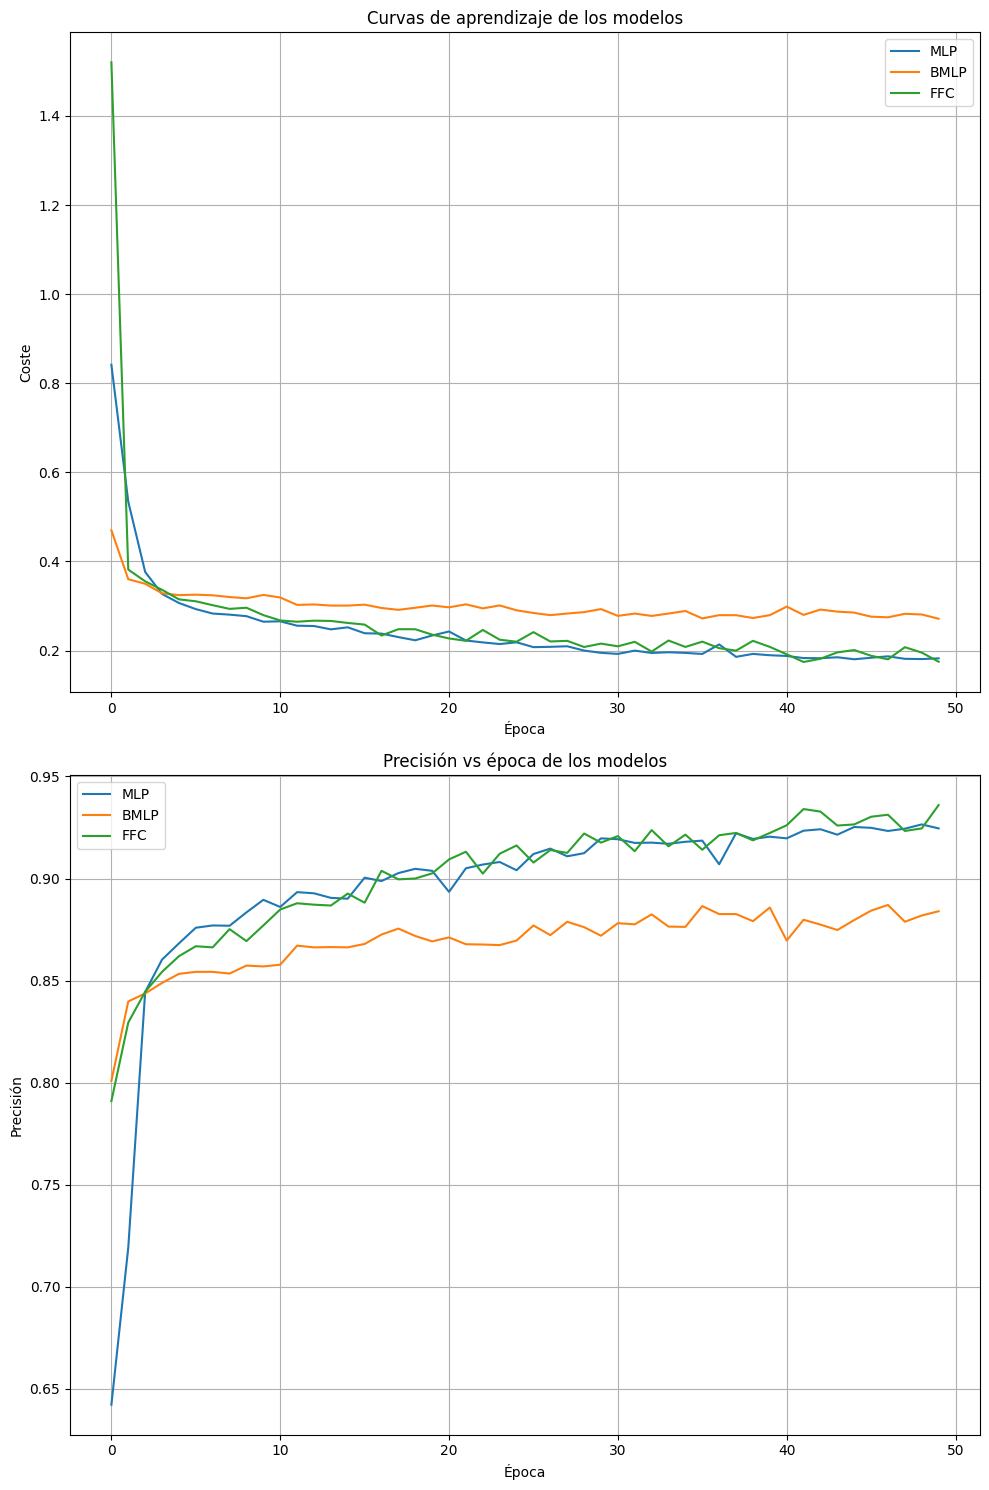

In [117]:
plt.figure(figsize=(10, 15))

# Curva de aprendizaje
plt.subplot(2, 1, 1)
for k in range(3):
    plt.plot(historial[k].history['loss'], label=modelos[k].name)
plt.title('Curvas de aprendizaje de los modelos')
plt.xlabel('Época')
plt.ylabel('Coste')
plt.legend()
plt.grid(True)

# Precisión vs época
plt.subplot(2, 1, 2)
for k in range(3):
    plt.plot(historial[k].history['accuracy'], label=modelos[k].name)
plt.title('Precisión vs época de los modelos')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Observando las gráficas superiores se puede ver claramante que el BMLP está por debajo de sus rivales en todos los aspectos. La precisión de sus pronóstivos se encuentra un 10% más baja y su coste en el entrenamiento es mucho mayor que el del resto de modelos.

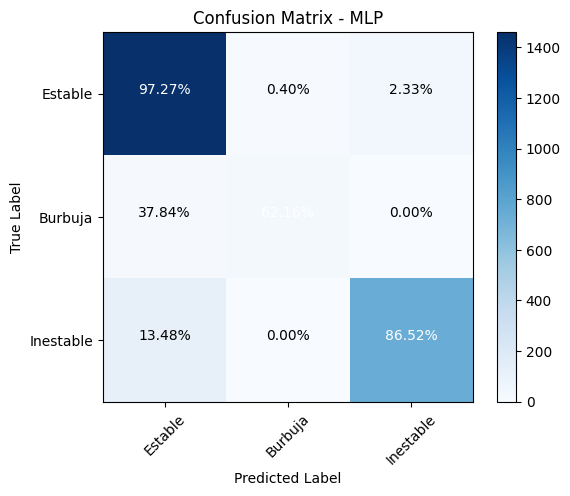

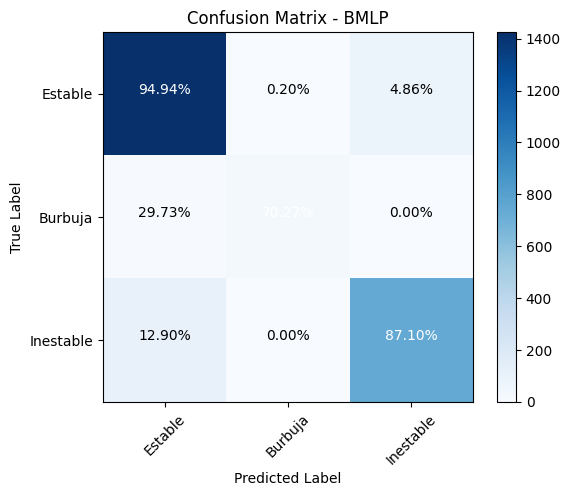

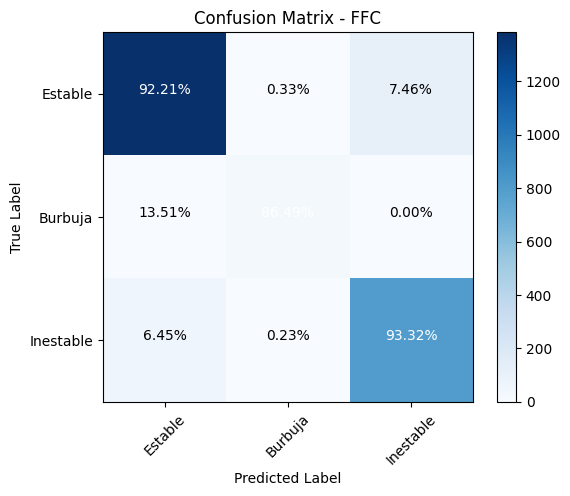

In [120]:
class_names = ['Estable', 'Burbuja', 'Inestable']

for i in range(len(modelos)):
    yhat = modelos[i].predict(Xtest, verbose=0)
    yhat = np.argmax(yhat, axis=1)
    cm = confusion_matrix(yTest.flatten(), yhat)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {modelos[i].name}')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Mostrar porcentajes en cada región
    total_samples = cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = cm.astype('float') / total_samples
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm_normalized[i, j], '.2%'),
                     horizontalalignment="center",
                     color="white" if cm_normalized[i, j] > 0.5 else "black")

    plt.show()


Revisando las matrices de confusión generadas a partir de los datos de test, se puede ver que ninguna de las 3 arquitecturas es perfecta. El MLP es el que mejor detecta el flujo estable, pero es el que más se equivoca al determinar si el flujo es inestable, o si hay burbujas de aire en el circuito. El BMLP es similar al MLP pero empeorando la tasa de acierto en flujo estable. Y el FFC a pesar de presentar la menor tasa de acierto de flujo estable, es el que menos se equivocaría a la hora de predecir inestabilidades y burbujas de aire en el circuito. Por ello, se considera que la FFC es la mejor red neuronal de las 3 comparadas.